# **Imports**

In [11]:
import os
import re
import warnings
warnings.filterwarnings('ignore')
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from textwrap import wrap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,TimeDistributed, Activation, Dropout, Flatten, Dense, Input, Layer


In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhil7280/coco-image-caption")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/coco-image-caption


In [13]:
import json

# Load the captions JSON file
with open('/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_train2017.json', 'r') as f:
    annotations = json.load(f)

# Create a mapping from image_id to captions
image_id_to_captions = {}
for annot in annotations['annotations']:
    image_id = annot['image_id']
    caption = annot['caption']
    if image_id not in image_id_to_captions:
        image_id_to_captions[image_id] = []
    image_id_to_captions[image_id].append(caption)

In [14]:
import json
import pandas as pd
import os

# Set the path to the COCO annotations file
annotations_path = "/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_train2014.json"

# Load the JSON file
with open(annotations_path, 'r') as f:
    coco_data = json.load(f)

# Create image_id to filename mapping
id_to_filename = {}
for item in coco_data['images']:
    # For example: image_id = 318556, file_name = 'COCO_train2014_000000318556.jpg'
    id_to_filename[item['id']] = item['file_name']

# Create a list of records
records = []
for ann in coco_data['annotations']:
    image_id = ann['image_id']
    caption = ann['caption']
    file_name = id_to_filename.get(image_id, None)
    if file_name:  # Only if mapping exists
        records.append({'image': file_name, 'caption': caption})

# Convert to DataFrame
df = pd.DataFrame(records)

# Show sample
df.head()

,image,caption
0,COCO_train2014_000000318556.jpg,A very clean and well decorated empty bathroom
1,COCO_train2014_000000116100.jpg,A panoramic view of a kitchen and all of its a...
2,COCO_train2014_000000318556.jpg,A blue and white bathroom with butterfly theme...
3,COCO_train2014_000000116100.jpg,A panoramic photo of a kitchen and dining room
4,COCO_train2014_000000379340.jpg,A graffiti-ed stop sign across the street from...


# **Images Exploration**

In [15]:
# Correct image path
image_path = "/kaggle/input/coco-image-caption/train2014/train2014"

# function to read the image and convert it from array to image
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img

# function to display some images
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"{image_path}/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

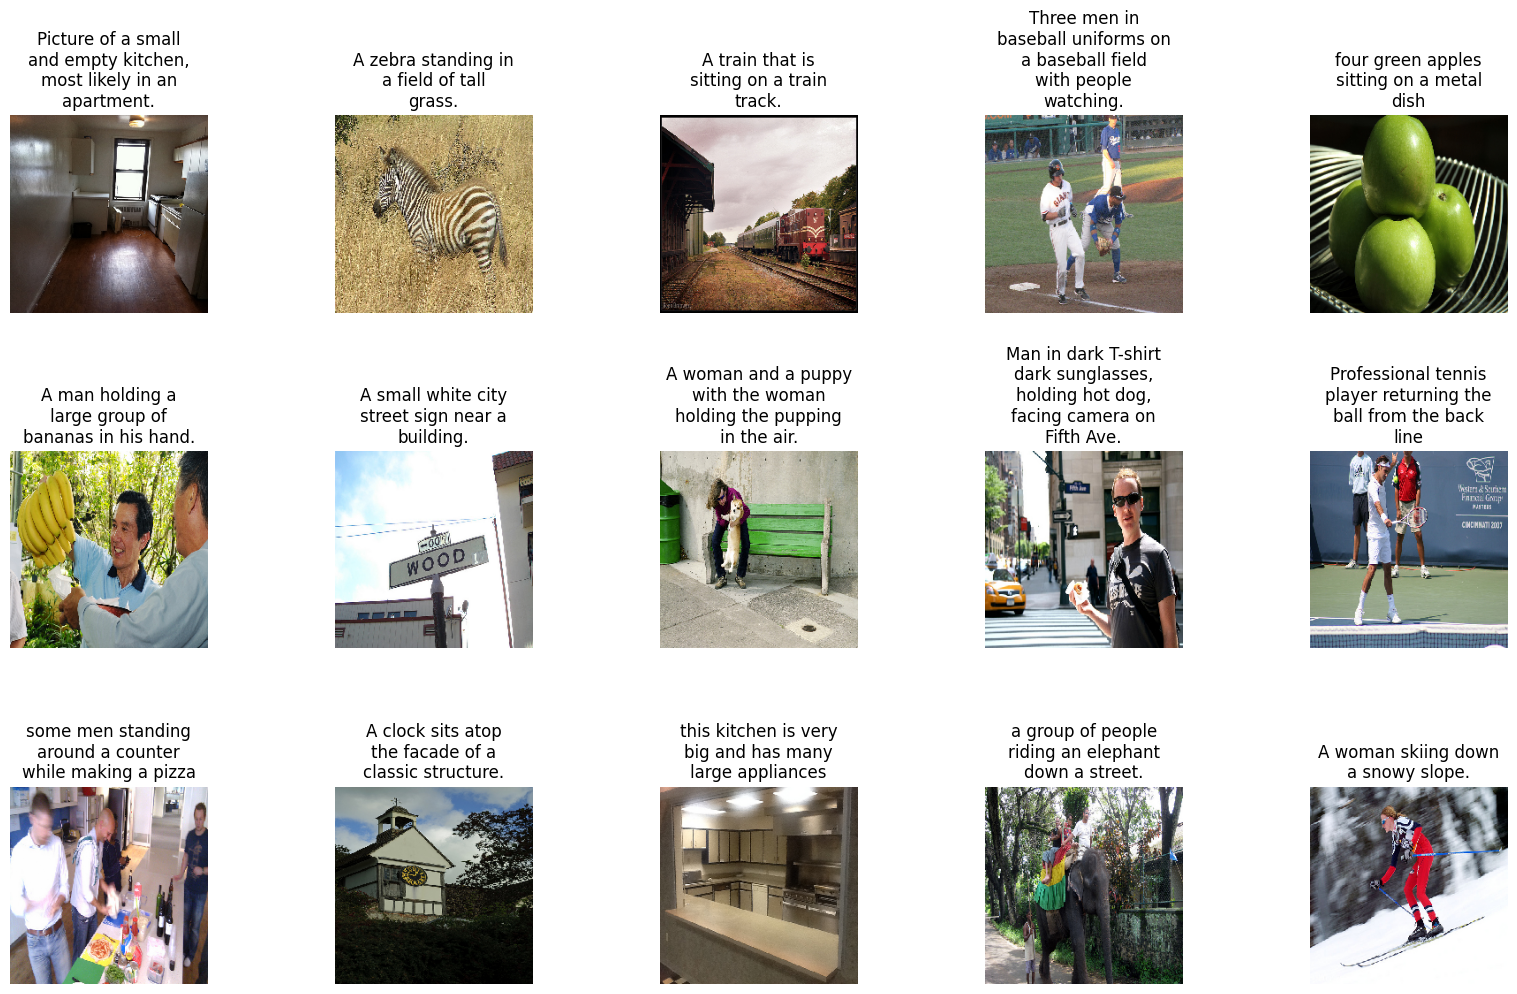

In [16]:
display_images(df.sample(15))

# **Preprocessing**

In [17]:
# Preprocessing function
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    data['caption'] = data['caption'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1 or word in ['a', 'i']]))
    data['caption'] = data['caption'].apply(lambda x: 'startseq ' + x + ' endseq') # put start of sequence and end of sequnce in each caption
    return data

In [18]:
# preprocess the captions
df = text_preprocessing(df)

# Get the captions in separate list
captions = df['caption'].tolist()
captions[:10]

['startseq a very clean and well decorated empty bathroom endseq',
 'startseq a panoramic view of a kitchen and all of its appliances endseq',
 'startseq a blue and white bathroom with butterfly themed wall tiles endseq',
 'startseq a panoramic photo of a kitchen and dining room endseq',
 'startseq a graffitied stop sign across the street from a red car endseq',
 'startseq a vandalized stop sign and a red beetle on the road endseq',
 'startseq a bathroom with a border of butterflies and blue paint on the walls above it endseq',
 'startseq an angled view of a beautifully decorated bathroom endseq',
 'startseq the two people are walking down the beach endseq',
 'startseq a sink and a toilet inside a small bathroom endseq']

# **Tokenization**

In [19]:
# Tokenizer to tokenize the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

# Get number of all words in the dataset
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions) # Get the maximum length of the caption

# Get only the unique images
unique_images = df['image'].unique()

# split images to train and validation
train_images, val_images = train_test_split(unique_images, test_size=0.15, random_state=42)

train = df[df['image'].isin(train_images)].reset_index(drop=True)
test = df[df['image'].isin(val_images)].reset_index(drop=True)

# tokenize one caption
tokenizer.texts_to_sequences([captions[1]])[0]

[2, 1, 3967, 171, 5, 1, 61, 9, 316, 5, 113, 610, 3]

# **ResNet Model and Feature Extraction**

In [20]:
# Initialize the model without the fully connected layer
model = ResNet152V2(weights='imagenet', include_top=False, pooling='avg')

# Set input image size for ResNet
img_size = 600
features = {}

# Loop through each unique image
for image in tqdm(df['image'].unique().tolist()):

    # Load and preprocess the image
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = preprocess_input(img)  # Use ResNet152V2's preprocessing
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Extract features
    feature = model.predict(img, verbose=0)
    features[image] = feature[0]

100%|██████████| 82783/82783 [3:22:34<00:00,  6.81it/s]  


In [22]:
len(features["COCO_train2014_000000000009.jpg"])

2048

# **LSTM Model Architecture**

In [29]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Dropout, LayerNormalization, Add, MultiHeadAttention
from keras.layers import Reshape

# Transformer Decoder Block
def transformer_decoder(inputs, encoder_output, vocab_size, max_length, num_heads=4, ff_dim=512, dropout_rate=0.1):
    # Self-attention
    attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=256)(inputs, inputs)
    attn1 = Dropout(dropout_rate)(attn1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn1)

    # Cross-attention with encoder (image) features
    attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=256)(out1, encoder_output)
    attn2 = Dropout(dropout_rate)(attn2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attn2)

    # Feed-forward
    ffn = tf.keras.Sequential([
        Dense(ff_dim, activation='relu'),
        Dense(256),
    ])
    ffn_output = ffn(out2)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    decoder_output = LayerNormalization(epsilon=1e-6)(out2 + ffn_output)

    return decoder_output

# Inputs
image_input = Input(shape=(2048,), name="image_input")                  # ResNet image feature
text_input = Input(shape=(max_length,), name="text_input")             # Caption token sequence

# Image embedding
img_embed = Dense(256, activation='relu')(image_input)
img_embed = LayerNormalization()(img_embed)
img_embed = Reshape((1, 256))(img_embed)                                # Add time dimension

# Word Embedding
word_embed = Embedding(input_dim=vocab_size, output_dim=256)(text_input)
word_embed = Dropout(0.1)(word_embed)

# Decoder with Transformer block
decoder_output = transformer_decoder(word_embed, img_embed, vocab_size, max_length)

# Output prediction
final_output = Dense(vocab_size, activation='softmax')(decoder_output[:, -1, :])  # Only last token output

# Build model
caption_model = Model(inputs=[image_input, text_input], outputs=final_output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

caption_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 51)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 51, 256)        │      6,242,048 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 51, 256)        │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 51, 256)        │      1,051,904 │ dropout_3[0][0],       │
│ (MultiHeadAttention)      │                        │                │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 51, 256)        │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        524,544 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 51, 256)        │              0 │ dropout_3[0][0],       │
│                           │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 256)            │            512 │ dense_3[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 51, 256)        │            512 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 256)         │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 51, 256)        │      1,051,904 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 51, 256)        │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 51, 256)        │              0 │ layer_normalization_2… │
│                           │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 51, 256)        │            512 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 51, 256)        │        262,912 │ layer_normalization_3… │
├──────────────────────

 Total params: 15,401,791 (58.75 MB)

 Trainable params: 15,401,791 (58.75 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
caption_model.summary() 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 51)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 51, 256)        │      6,242,048 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 51, 256)        │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 51, 256)        │      1,051,904 │ dropout_3[0][0],       │
│ (MultiHeadAttention)      │                        │                │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 51, 256)        │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        524,544 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 51, 256)        │              0 │ dropout_3[0][0],       │
│                           │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 256)            │            512 │ dense_3[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 51, 256)        │            512 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 256)         │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 51, 256)        │      1,051,904 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 51, 256)        │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 51, 256)        │              0 │ layer_normalization_2… │
│                           │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 51, 256)        │            512 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 51, 256)        │        262,912 │ layer_normalization_3… │
├──────────────────────

 Total params: 15,401,791 (58.75 MB)

 Trainable params: 15,401,791 (58.75 MB)

 Non-trainable params: 0 (0.00 B)

# **Creat the Caption Generator Class**

In [32]:
class CaptionDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [33]:
train_generator = CaptionDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CaptionDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# **Train the Model**

In [34]:
model_name = "/kaggle/working/model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [35]:
history = caption_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/10
5499/5499 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 3.3599
Epoch 1: val_loss improved from inf to 2.60223, saving model to /kaggle/working/model.keras
5499/5499 ━━━━━━━━━━━━━━━━━━━━ 3411s 617ms/step - loss: 3.3598 - val_loss: 2.6022 - learning_rate: 0.0010
Epoch 2/10
5499/5499 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 2.4957
Epoch 2: val_loss improved from 2.60223 to 2.53203, saving model to /kaggle/working/model.keras
5499/5499 ━━━━━━━━━━━━━━━━━━━━ 1827s 332ms/step - loss: 2.4957 - val_loss: 2.5320 - learning_rate: 0.0010
Epoch 3/10
5499/5499 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 2.3607
Epoch 3: val_loss improved from 2.53203 to 2.49759, saving model to /kaggle/working/model.keras
5499/5499 ━━━━━━━━━━━━━━━━━━━━ 1803s 328ms/step - loss: 2.3607 - val_loss: 2.4976 - learning_rate: 0.0010
Epoch 4/10
5499/5499 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 2.2789
Epoch 4: val_loss improved from 2.49759 to 2.49255, saving model to /kaggle/working/model.keras
5499/5499 ━━━━━━━━

# **Test the Model**

In [36]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [50]:
# Generate caption
def generate_caption(model, tokenizer, photo_feature, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo_feature.reshape((1, 2048)), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = next((w for w, idx in tokenizer.word_index.items() if idx == yhat), None)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return ' '.join(in_text.split()[1:])  # remove 'startseq'

def Image_caption(image_name, images_path="/kaggle/input/many-jpg"):
    # Load and preprocess the image
    image_path = os.path.join(images_path, image_name)
    img = load_img(image_path, target_size=(600, 600))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # # Load and preprocess the image
    # img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    # img = img_to_array(img)
    # img = preprocess_input(img)  # Use ResNet152V2's preprocessing
    # img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Extract features using ResNet152V2
    model_resnet = ResNet152V2(weights='imagenet', include_top=False, pooling='avg')
    photo_feature = model_resnet.predict(img_array, verbose=0)

    # Show image
    img_show = mpimg.imread(image_path)
    plt.imshow(img_show)
    plt.axis('off')
    plt.show()

    # Generate caption
    caption = generate_caption(caption_model, tokenizer, photo_feature, max_length)
    print("Caption:", caption)
    return caption

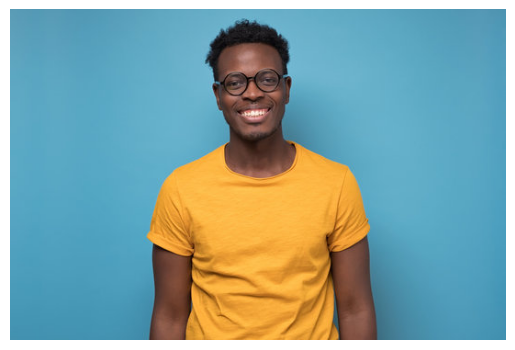

Caption: a man with a shirt and tie standing in front of a camera


In [51]:
capti = Image_caption("many.jpg")

# **Save**

In [52]:
import pickle
from google.colab import files
from keras.models import load_model

In [61]:
caption_model.save('/kaggle/working/caption_model.keras')

In [69]:
with open('/kaggle/working/tokenizer2.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [70]:
files.download('tokenizer2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
# Save precomputed features
with open('/kaggle/working/image_features2.pkl', 'wb') as f:
    pickle.dump(features, f)

In [72]:
# Download from Colab
from google.colab import files
files.download('image_features2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Inference**

In [37]:
caption_model2 = load_model('/content/caption_model_final2.keras')

In [38]:
# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer2 = pickle.load(f)

In [39]:
# Load precomputed features
with open('image_features.pkl', 'rb') as f:
    features2 = pickle.load(f)

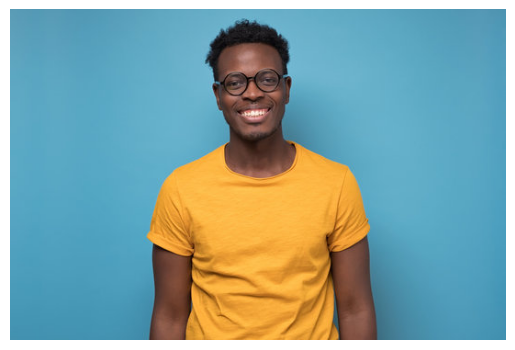

Caption: a man with a shirt and tie standing in front of a camera


In [73]:
capti = Image_caption("many.jpg")